Notebook from https://brainiak.org/tutorials/08-connectivity/

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import os 
import nibabel as nib
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn import plotting
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from scipy import stats
from scipy.ndimage.measurements import center_of_mass
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
#import brainiak.utils.fmrisim as sim
#from brainiak.fcma.util import compute_correlation
from nilearn import input_data
import time
#from utils import shift_timing

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


In [2]:
datadir='/home/data/refined/microbiome2brain/MRI/bids_dataset'
from bids.grabbids import BIDSLayout
layout = BIDSLayout(datadir)

Failed to import duecredit due to No module named 'duecredit'


In [3]:
source_epi = layout.get(type="bold", task="rest", session="01", extensions="nii.gz")[0]
source_epi.subject
runs = (1,2)

# Group-analysis of seed-based connectivity from xcpEngine

## import seed-based connectivity

In [ ]:
nii1 = {}
for i in range(7):
    source_epi = layout.get(type="bold", task="image", session="01", extensions="nii.gz")[i]
    in_file=os.path.join(datadir, "derivatives", "xcpOutput",
                         "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session,"run-1",
                         "seed", "RHC",
                         "sub-%s_ses-%s_run-1_connectivity_RHCZ_sm8.nii.gz"%(source_epi.subject,source_epi.session))
    nii1[i] = in_file
    
nii2 = {}
for i in range(7):
    source_epi = layout.get(type="bold", task="image", session="02", extensions="nii.gz")[i]
    in_file=os.path.join(datadir, "derivatives", "xcpOutput",
                         "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session,"run-1",
                         "seed", "RHC",
                         "sub-%s_ses-%s_run-1_connectivity_RHCZ_sm8.nii.gz"%(source_epi.subject,source_epi.session))
    nii2[i+7] = in_file


In [73]:
nii = nii1.copy()
nii.update(nii2)

In [74]:
nii1

{0: '/home/data/refined/microbiome2brain/MRI/bids_dataset/derivatives/xcpOutput/sub-E1/ses-01/run-1/seed/RHC/sub-E1_ses-01_run-1_connectivity_RHCZ_sm5.nii.gz',
 1: '/home/data/refined/microbiome2brain/MRI/bids_dataset/derivatives/xcpOutput/sub-E2/ses-01/run-1/seed/RHC/sub-E2_ses-01_run-1_connectivity_RHCZ_sm5.nii.gz',
 2: '/home/data/refined/microbiome2brain/MRI/bids_dataset/derivatives/xcpOutput/sub-E3/ses-01/run-1/seed/RHC/sub-E3_ses-01_run-1_connectivity_RHCZ_sm5.nii.gz',
 3: '/home/data/refined/microbiome2brain/MRI/bids_dataset/derivatives/xcpOutput/sub-E4/ses-01/run-1/seed/RHC/sub-E4_ses-01_run-1_connectivity_RHCZ_sm5.nii.gz',
 4: '/home/data/refined/microbiome2brain/MRI/bids_dataset/derivatives/xcpOutput/sub-E5/ses-01/run-1/seed/RHC/sub-E5_ses-01_run-1_connectivity_RHCZ_sm5.nii.gz',
 5: '/home/data/refined/microbiome2brain/MRI/bids_dataset/derivatives/xcpOutput/sub-F1/ses-01/run-1/seed/RHC/sub-F1_ses-01_run-1_connectivity_RHCZ_sm5.nii.gz',
 6: '/home/data/refined/microbiome2brain

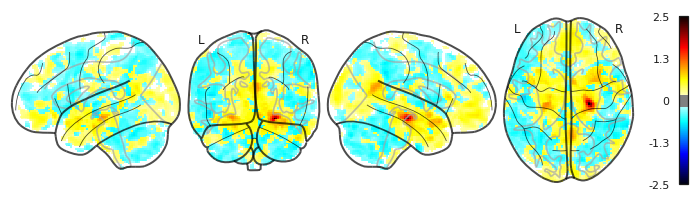

In [75]:
E1A = nib.load(nii1[0])

plotting.plot_glass_brain(
    nii1[0], 
    threshold=0.2,
    colorbar=True, 
    plot_abs=False,
    display_mode='lyrz', 
)

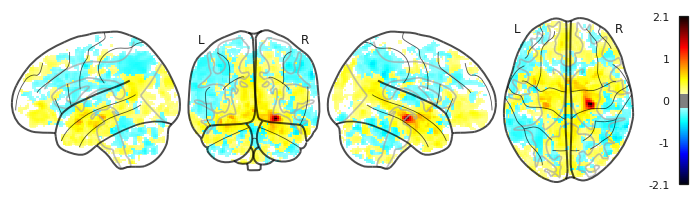

In [79]:
plotting.plot_glass_brain(
    nii2[7], 
    threshold=0.2,
    colorbar=True, 
    plot_abs=False,
    display_mode='lyrz', 
)

In [76]:
from nilearn.image import get_data

fmri_data = get_data(nii.values())

In [77]:
fmri_data.shape

(97, 115, 97, 14)

In [78]:
ses01_data = get_data(nii1.values())
ses02_data = get_data(nii2.values())

In [60]:
fmri_data[..., range(7,14)].shape

(97, 115, 97, 7)

In [61]:
ses01_data.shape

(97, 115, 97, 7)

(97, 115, 97)


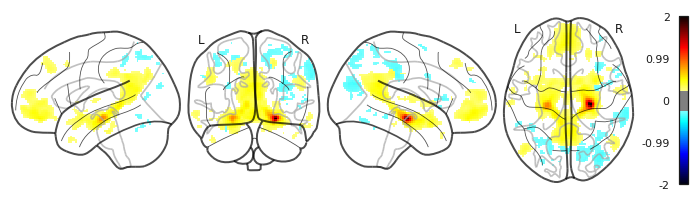

In [81]:
from nilearn.image import mean_img

ses01 = mean_img(nii1.values())
print(ses01.shape)

plotting.plot_glass_brain(
    ses01, 
    threshold=0.25,
    colorbar=True, 
    plot_abs=False,
    display_mode='lyrz', 
)


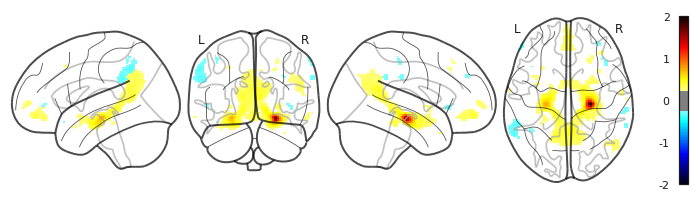

In [82]:
ses02 = mean_img(nii2.values())
plotting.plot_glass_brain(
    ses02, 
    threshold=0.25,
    colorbar=True, 
    plot_abs=False,
    display_mode='lyrz', 
)

In [83]:
coords_RHC = [(26, -21, -14)]
masker_RHC = input_data.NiftiSpheresMasker(
    coords_RHC, 
    radius=5, standardize=True, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0
)

masker_wb = input_data.NiftiMasker(
    standardize=True,  # Are you going to zscore the data across time?
    #t_r=2, 
    #detrend=True,
    #smoothing_fwhm=8,
    #low_pass=0.09, high_pass=0.008,
    memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
    memory_level=1,  # How much memory will you cache?
    verbose=0
)


# Mask the epi data and get a time series for the ROI
zscore_RHC_ses01 = masker_wb.fit_transform(ses01)
zscore_RHC_ses02 = masker_wb.fit_transform(ses02)

e1a = masker_wb.fit_transform(nii1[0])
e1b = masker_wb.fit_transform(nii2[7])



In [84]:
print(np.sum(e1a[e1a > 0.25]))
print(np.sum(e1b[e1b > 0.25]))

2048.1519
6809.5254


In [66]:
print(np.sum(e5a[e5a > 0.25]))
print(np.sum(e5b[e5b > 0.25]))

14336.3545
8559.23


In [16]:
zscore_RHC_ses01.T.shape

(236206, 1)

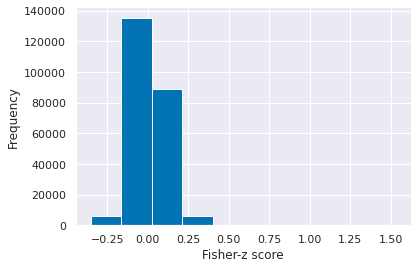

In [67]:
plt.hist(zscore_RHC_ses01.T)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');
sns.despine()

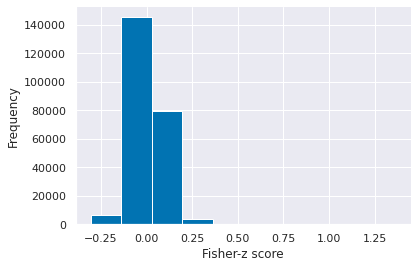

In [68]:
plt.hist(zscore_RHC_ses02.T)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');
sns.despine()

In [69]:
print(zscore_RHC_ses01.max())

1.5290481


In [70]:
print(zscore_RHC_ses01.shape)

(1, 236206)


In [71]:
print(np.sum(zscore_RHC_ses01[zscore_RHC_ses01 > 0.25]))
print(np.sum(zscore_RHC_ses02[zscore_RHC_ses02 > 0.25]))

1174.1721
595.4376


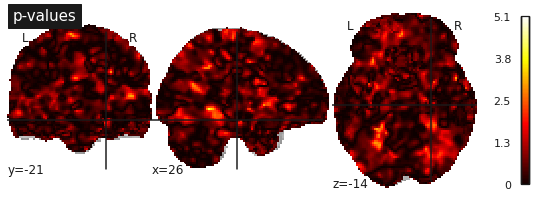

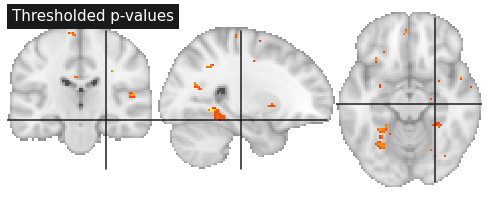

In [31]:
import numpy as np
from scipy import stats

# This test returns p-values that represent probabilities that the two
# time-series were not drawn from the same distribution. The lower the
# p-value, the more discriminative is the voxel in distinguishing the two
# conditions (faces and houses).
_, p_values = stats.ttest_rel(ses01_data,
                              ses02_data,
                              axis=-1)

# Use a log scale for p-values
log_p_values = -np.log10(p_values)
# NAN values to zero
log_p_values[np.isnan(log_p_values)] = 0.
log_p_values[log_p_values > 10.] = 10.

# Visualize statistical p-values using plotting function `plot_stat_map`
from nilearn.plotting import plot_stat_map

# Before visualizing, we transform the computed p-values to Nifti-like image
# using function `new_img_like` from nilearn.
from nilearn.image import new_img_like

# First argument being a reference image and second argument should be p-values
# data to convert to a new image as output. This new image will have same header
# information as reference image.
fmri_img = nib.load(nii1[0])
log_p_values_img = new_img_like(fmri_img, log_p_values)

# Now, we visualize log p-values image on functional mean image as background
# with coordinates given manually and colorbar on the right side of plot (by
# default colorbar=True)
from nilearn import image
mean_img = image.mean_img(fmri_img)
plot_stat_map(log_p_values_img, 
              title="p-values", cut_coords=coords_RHC[0])

# Note that we use log p-values data; we force values below 5 to 0 by
# thresholding.
log_p_values[log_p_values < 2.3] = 0

# Visualize the reduced voxels of interest using statistical image plotting
# function. As shown above, we first transform data in array to Nifti image.
log_p_values_img = new_img_like(fmri_img, log_p_values)

# Now, visualizing the created log p-values to image without colorbar and
# without Left - 'L', Right - 'R' annotation
plot_stat_map(log_p_values_img,
              title='Thresholded p-values', annotate=False,
              colorbar=False, cut_coords=coords_RHC[0])

In [8]:
dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
labels = [
    'Posterior Cingulate Cortex',
    'Left Temporoparietal junction',
    'Right Temporoparietal junction',
    'Medial prefrontal cortex',
    ]

masker_dmn = input_data.NiftiSpheresMasker(
    dmn_coords, 
    radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=2)

# Mask the epi data and get a time series for the ROI
bold_dmn_E1A = masker_dmn.fit_transform(res1[0])

________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/data/refined/microbiome2brain/MRI/bids_dataset/derivatives/xcpOutput/sub-E1/ses-01/run-1/regress/sub-E1_ses-01_run-1_residualised.nii.gz', 
{ 'allow_overlap': False,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.01,
  'high_variance_confounds': False,
  'low_pass': 0.1,
  'mask_img': None,
  'radius': 8,
  'seeds': [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)],
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  't_r': 2}, confounds=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=2)
[NiftiSpheresMasker.transform_single_imgs] Loading data from /home/data/refined/microbiome2brain/MRI/bids_dataset/derivatives/xcpOutput/sub-E1/ses-01/run-1/regress/sub-E1_ses-01_run-1_residualised.nii.gz
[NiftiSpheresMasker.transform_single_im

In [14]:
bold_dmn_E1A = masker_dmn.fit_transform(res1[0])

[Memory]396.7s, 6.6min  : Loading filter_and_extract...


In [15]:
from nilearn.connectome import ConnectivityMeasure
connectivity_measure = ConnectivityMeasure(kind='partial correlation')
partial_correlation_matrix = connectivity_measure.fit_transform([bold_dmn_E1A])[0]

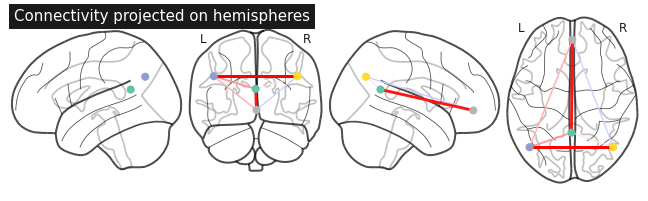

In [17]:
from nilearn import plotting
plotting.plot_connectome(partial_correlation_matrix, dmn_coords,
                         title="Connectivity projected on hemispheres",
                         display_mode='lyrz')

plotting.show()

In [18]:
power = datasets.fetch_coords_power_2011()
print('Power atlas comes with {0}.'.format(power.keys()))

Power atlas comes with dict_keys(['rois', 'description']).


In [19]:
import numpy as np

coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

print('Stacked power coordinates in array of shape {0}.'.format(coords.shape))

Stacked power coordinates in array of shape (264, 3).


In [20]:
spheres_masker = input_data.NiftiSpheresMasker(
    seeds=coords, smoothing_fwhm=6, radius=5.,
    detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=2)

#timeseries = spheres_masker.fit_transform(func_filename,
#                                          confounds=confounds_filename)

timeseries = spheres_masker.fit_transform(res1[0])

In [21]:
print('time series has {0} samples'.format(timeseries.shape[0]))

time series has 300 samples


In [22]:
try:
    from sklearn.covariance import GraphicalLassoCV
except ImportError:
    # for Scitkit-Learn < v0.20.0
    from sklearn.covariance import GraphLassoCV as GraphicalLassoCV

covariance_estimator = GraphicalLassoCV(cv=3, verbose=1)

In [23]:
covariance_estimator.fit(timeseries)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GraphicalLassoCV] Done refinement  1 out of 4:   7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GraphicalLassoCV] Done refinement  2 out of 4:  35s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GraphicalLassoCV] Done refinement  3 out of 4:  60s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.1s finished


[GraphicalLassoCV] Done refinement  4 out of 4:  84s


GraphicalLassoCV(alphas=4, assume_centered=False, cv=3, enet_tol=0.0001,
                 max_iter=100, mode='cd', n_jobs=None, n_refinements=4,
                 tol=0.0001, verbose=1)

In [24]:
matrix = covariance_estimator.covariance_
print('Covariance matrix has shape {0}.'.format(matrix.shape))

Covariance matrix has shape (264, 264).


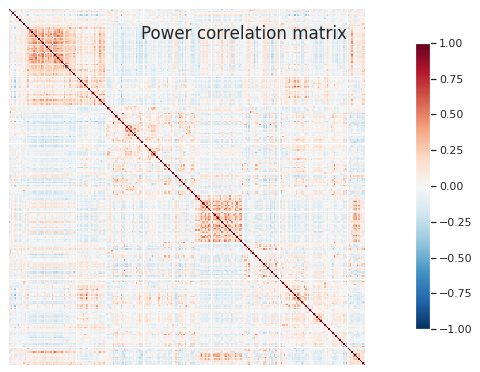

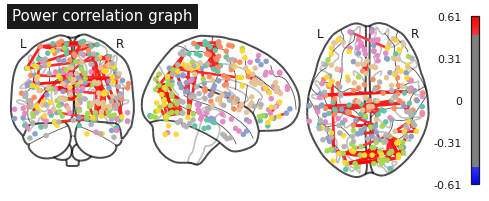

In [25]:
from nilearn import plotting

plotting.plot_matrix(matrix, vmin=-1., vmax=1., colorbar=True,
                     title='Power correlation matrix')

# Tweak edge_threshold to keep only the strongest connections.
plotting.plot_connectome(matrix, coords, title='Power correlation graph',
                         edge_threshold='99.8%', node_size=20, colorbar=True)


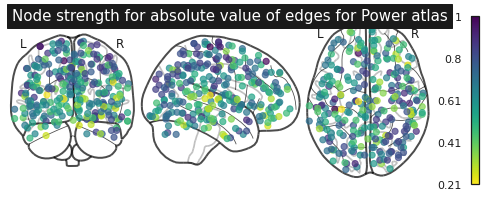

In [26]:
# calculate normalized, absolute strength for each node
node_strength = np.sum(np.abs(matrix), axis=0)
node_strength /= np.max(node_strength)

plotting.plot_markers(
    node_strength,
    coords,
    title='Node strength for absolute value of edges for Power atlas',
)

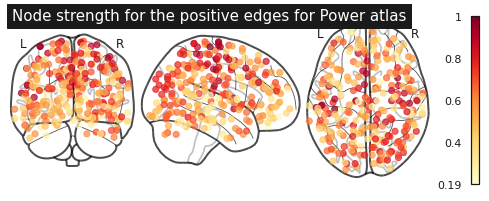

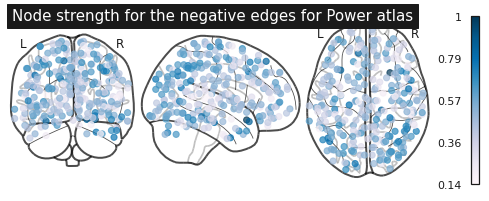

In [27]:
from matplotlib.pyplot import cm

# clip connectivity matrix to preserve positive and negative edges
positive_edges = np.clip(matrix, 0, matrix.max())
negative_edges = np.clip(matrix, matrix.min(), 0)

# calculate strength for positive edges
node_strength_positive = np.sum(np.abs(positive_edges), axis=0)
node_strength_positive /= np.max(node_strength_positive)

# calculate strength for negative edges
node_strength_negative = np.sum(np.abs(negative_edges), axis=0)
node_strength_negative /= np.max(node_strength_negative)

# plot nodes' strength for positive edges
plotting.plot_markers(
    node_strength_positive,
    coords,
    title='Node strength for the positive edges for Power atlas',
    node_cmap=cm.YlOrRd
)

# plot nodes' strength for negative edges
plotting.plot_markers(
    node_strength_negative,
    coords,
    title='Node strength for the negative edges for Power atlas',
    node_cmap=cm.PuBu
)

# Redo see-based connectivity analysis using residualized image from xcpOutput

## Mask and extract the whole-brain data

In [106]:
res1 = {}
for i in range(7):
    source_epi = layout.get(type="bold", task="image", session="01", extensions="nii.gz")[i]
    in_file=os.path.join(datadir, "derivatives", "xcpOutput",
                         "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session,"run-1",
                         "regress",
                         "sub-%s_ses-%s_run-1_residualised.nii.gz"%(source_epi.subject,source_epi.session))
    res1[i] = in_file


In [107]:
# Init a masker object that also standardizes the data
masker_wb = input_data.NiftiMasker(
    standardize=True,  # Are you going to zscore the data across time?
    t_r=2, 
    memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
    memory_level=1,  # How much memory will you cache?
    verbose=0
)


In [108]:
# Pull out the time course for voxel
bold_wb = masker_wb.fit_transform(res1[0])

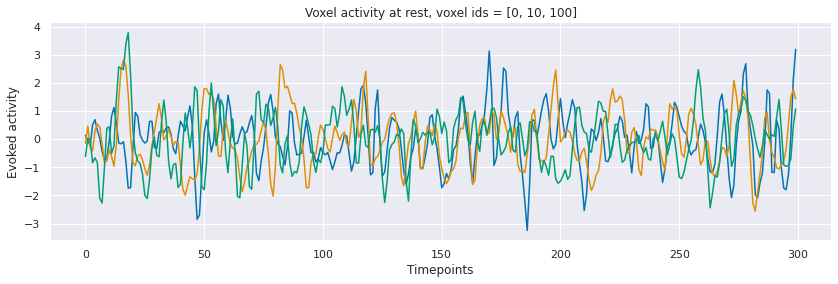

In [109]:
"""
Plot the timeseries for a few voxels
"""
voxel_ids = [0,10,100]

plt.figure(figsize=(14, 4))
plt.title('Voxel activity at rest, voxel ids = ' + str(voxel_ids));
plt.plot(bold_wb[:, voxel_ids]);
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');
sns.despine()

## create spherical seed ROI and extract signal

In [110]:
coords_RHC = [(26, -18, 16)]
masker_RHC = input_data.NiftiSpheresMasker(
    coords_RHC, 
    radius=8, standardize=True, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0
)

# Mask the epi data and get a time series for the ROI
bold_RHC_E1A = masker_RHC.fit_transform(nii1[0])
bold_RHC_E2A = masker_RHC.fit_transform(nii1[1])

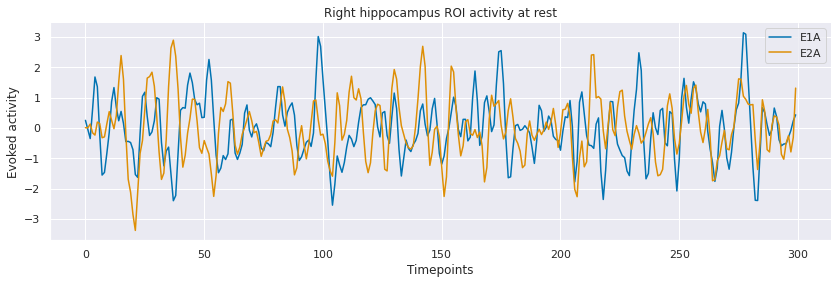

In [111]:
plt.figure(figsize=(14, 4))
plt.title('Right hippocampus ROI activity at rest')
plt.plot(bold_RHC_E1A);
plt.plot(bold_RHC_E2A);
plt.legend(('E1A', 'E2A'));
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');
sns.despine()

## compute the correlation matrix

In [112]:
def seed_correlation(wbBold, seedBold):
    """Compute the correlation between a seed voxel vs. other voxels 
    Parameters
    ----------
    wbBold [2d array], n_stimuli x n_voxels 
    seedBold, 2d array, n_stimuli x 1

    Return
    ----------    
    seed_corr [2d array], n_stimuli x 1
    seed_corr_fishZ [2d array], n_stimuli x 1
    """
    num_voxels = wbBold.shape[1]
    seed_corr = np.zeros((num_voxels, 1))
    for v in range(num_voxels):    
        seed_corr[v, 0] = np.corrcoef(seedBold.flatten(), wbBold[:, v])[0, 1]
    # Transfrom the correlation values to Fisher z-scores    
    seed_corr_fishZ = np.arctanh(seed_corr)
    return seed_corr, seed_corr_fishZ

Seed-based correlation Fisher-z transformed: min = -0.492; max = 0.624


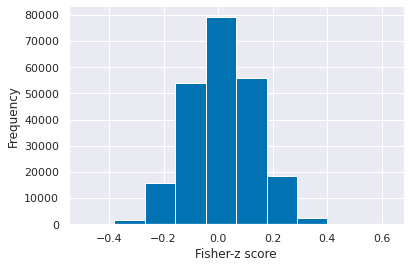

In [113]:
# Let's use the function and print out the range of results
corr_RHC, corr_fz_RHC = seed_correlation(bold_wb, bold_RHC_E1A)
print("Seed-based correlation Fisher-z transformed: min = %.3f; max = %.3f" % (
    corr_fz_RHC.min(), corr_fz_RHC.max()
))


# A histogram is always a useful first way of looking at your data.
plt.hist(corr_fz_RHC)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');
sns.despine()


In [118]:
print(corr_fz_RHC.shape)
conn = corr_fz_RHC[abs(corr_fz_RHC) > 0.25]
conn.shape


(227901, 1)


(8900,)

In [50]:
# We can tranform the correlation array back to a Nifti image object that we can save
img_corr_RHC= masker_wb.inverse_transform(corr_fz_RHC.T)
img_corr_RHC.to_filename(os.path.join(datadir, "derivatives", "rsConn",'sub-E1A_ses-01_run-1_RHCcorr.nii.gz'))

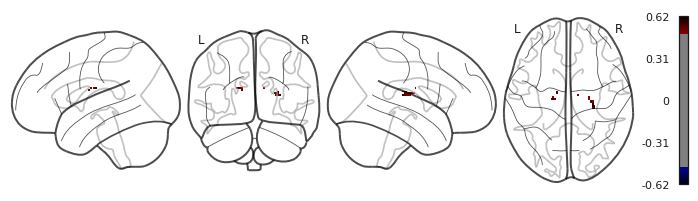

In [51]:
threshold = .5
plotting.plot_glass_brain(
    img_corr_RHC, 
    threshold=threshold,
    colorbar=True, 
    plot_abs=False,
    display_mode='lyrz', 
)

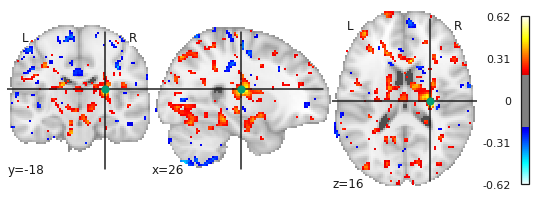

In [53]:
# Let's also visualize the correlation of the seed with every voxel
threshold = .2

# Nilearn has useful tools for plotting our results as a map
map_ar = plotting.plot_stat_map(
    img_corr_RHC, 
    threshold=threshold,
    cut_coords=coords_RHC[0],
)
# Add the seed
map_ar.add_markers(
    marker_coords=coords_RHC, 
    marker_color='g',
    marker_size=50
)